# Boosting on CGC Data

In [15]:
def load_cgc_metadata():
    import pandas as pd, os
    metadata = pd.DataFrame()

    for file in os.listdir(os.path.dirname(os.path.dirname(os.getcwd()))+"\\Data\\GeneExpression\\"):
        if "manifest" in file:
            if metadata.empty:
                metadata = pd.read_csv(os.path.dirname(os.path.dirname(os.getcwd()))+"\\Data\\GeneExpression\\" + file).loc[:, ["name", "disease_type", "id", 'vital_status']]
            else:
                data = pd.read_csv(os.path.dirname(os.path.dirname(os.getcwd()))+"\\Data\\GeneExpression\\" + file).loc[:, ["name", "disease_type", "id", 'vital_status']]
                metadata = pd.concat([metadata, data])

    metadata = metadata.reset_index(drop= True).drop_duplicates()

    return metadata

def load_cgc_data():
    import pandas as pd, os

    metadata = load_cgc_metadata()
    
    directory = os.path.dirname(os.path.dirname(os.getcwd())) + "\\Data\\GeneExpression\\Files\\"
    master = pd.DataFrame()

    for file in os.listdir(directory):
        tsv_file_path = directory + file

        df = pd.read_csv(tsv_file_path, sep='\t')
        df = pd.DataFrame(df.set_index("miRNA_ID")["reads_per_million_miRNA_mapped"]).rename(columns={"reads_per_million_miRNA_mapped":file}).T

        master = pd.concat([master,df])
    
    df = metadata.set_index("name").join(master).set_index("id")
        
    return df

In [23]:
df = load_cgc_data()

## Pre-processing

In [27]:
from sklearn.model_selection import train_test_split

In [43]:
# Drop unknown vital status
df2 = df[df["vital_status"] != "Unknown"]

In [45]:
X = df.drop(columns = ["disease_type", "vital_status"])
binary_y = df["vital_status"].apply(lambda x: 1 if x == "Alive" else 0)
multiclass_y = df["disease_type"]


In [46]:
X_train, X_test, binary_y_train, binary_y_test = train_test_split(X, binary_y, train_size=0.7)
X_train, X_test, multiclass_y_train, multiclass_y_test = train_test_split(X, multiclass_y, train_size=0.7)


## Binary ADA Boost
Here we will be using miRNA counts as predictors and vital status (aka whether the patient has survived the cancer (1) or not (0)) as the target.

In [21]:
from sklearn.ensemble import AdaBoostClassifier

In [47]:
binary_classifier = AdaBoostClassifier()
binary_classifier.fit(X_train, binary_y_train)

AdaBoostClassifier()

In [59]:
weights = binary_classifier.decision_function(X_test) >= 0

array([0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0], dtype=int64)

In [60]:
predictions = binary_classifier.predict(X_test)

array([0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0], dtype=int64)

The decision function essentially gives us the weighted average of the weak classifiers whereas predict returns the sign of the decision function, which in the end is the class predicton.

In [62]:
def cm_mapper(actual, predictions):
    import numpy as np
    mapping = []
    for i in range(len(predictions)):

        if predictions[i]:
            if actual[i]:
                mapping.append("TP")
            else:
                mapping.append('FP')
        else:
            if actual[i]:
                mapping.append('FN')
            else:
                mapping.append('TN')

    return np.array(mapping)

In [67]:
import pandas as pd
weights = binary_classifier.decision_function(X_test)
predictions = binary_classifier.predict(X_test)
cm = cm_mapper(predictions, binary_y_test)

results = pd.DataFrame({'Actual':binary_y_test, 'Predicted':predictions, 'Weight':weights, "Outcome":cm})

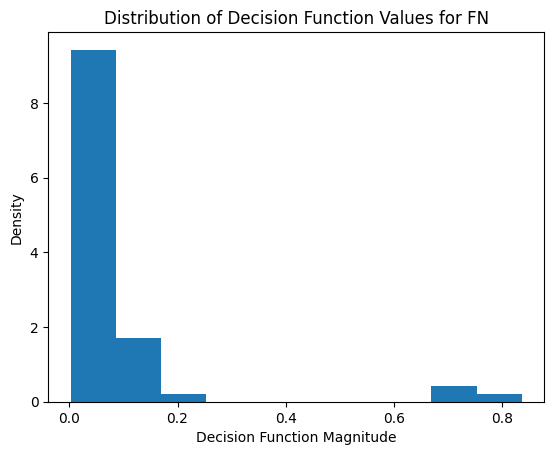

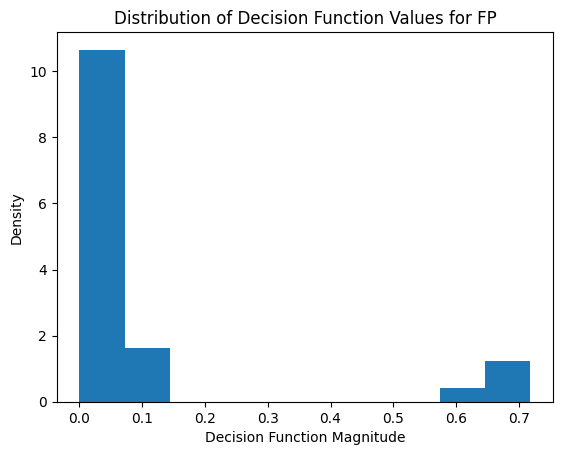

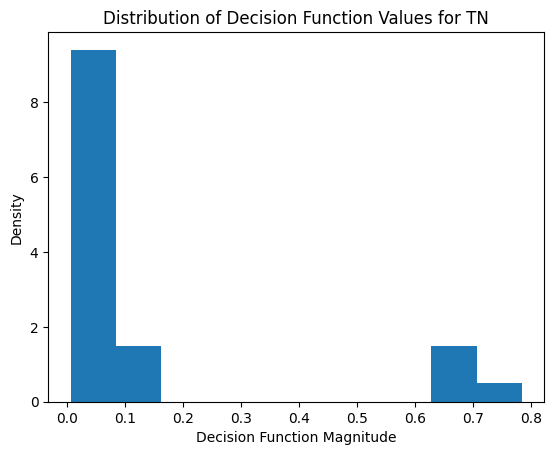

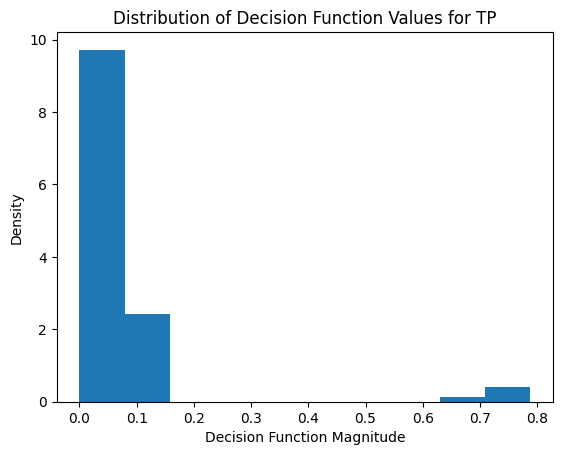

In [88]:
import matplotlib.pyplot as plt
groups = results.groupby('Outcome')
for name, group in groups:
    plt.hist(abs(group.Weight), density=True)
    plt.title("Distribution of Decision Function Values for " + name)
    plt.xlabel("Decision Function Magnitude")
    plt.ylabel("Density")
    plt.show()


If the magnitude of the decision function is high then you would expect that the model is very sure about the decision it is making. I would assume that these values would surely be true positives and true negatives. Looking at the graphs, it turns out that the distribution of the decision function value is roughly the same for True Positives, True Negatives, False Positives, and False Negatives. 

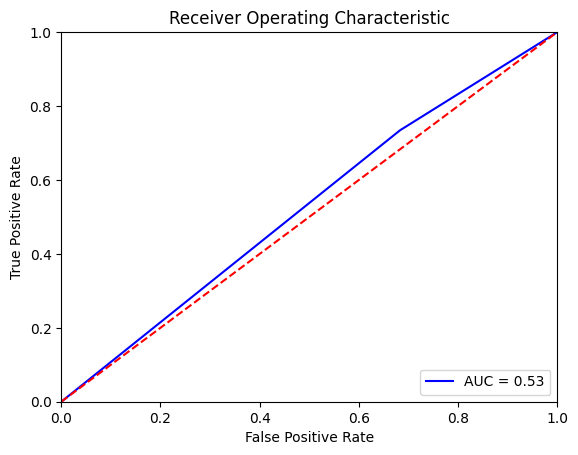

In [90]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(binary_y_test, predictions)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [103]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score

print("Confusion Matrix:\n", confusion_matrix(binary_y_test, predictions)) 
print("Accuracy = ", binary_classifier.score(X_test, binary_y_test))
print("Kappa = ", cohen_kappa_score(binary_y_test, predictions))

Confusion Matrix:
 [[26 56]
 [34 94]]
Accuracy =  0.5714285714285714
Kappa =  0.05405405405405406


Our confusion matrix shows a very poor accuracy and our kappa value is not very high either

The first attempt at boosting has not resulted in a very successful model.

### Exponential Loss

### Hyperparameter Tuning

In [110]:
from sklearn.model_selection import cross_val_score

In [116]:
# Number of estimators

estimators = [10,50,100,150,200]
score = []

for n in estimators:

    classifier = AdaBoostClassifier(n_estimators= n)
    score.append(cross_val_score(classifier, X_train, binary_y_train).mean())
    

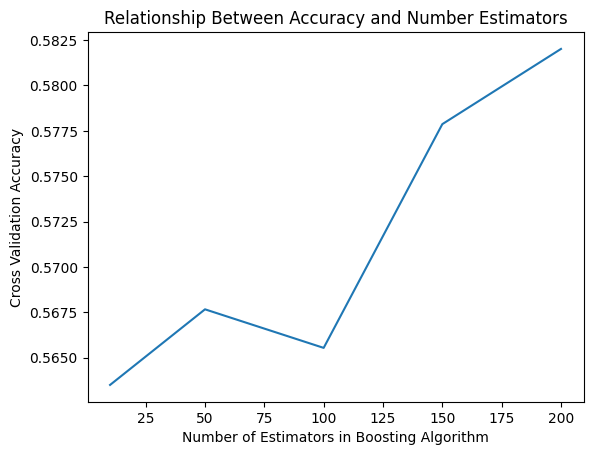

In [129]:
plt.plot(estimators, score)
plt.title("Relationship Between Accuracy and Number Estimators")
plt.ylabel("Cross Validation Accuracy")
plt.xlabel("Number of Estimators in Boosting Algorithm")
plt.show()

In [137]:
print("Estimated accuracy gained per estimator: {:.2f}%".format((score[-1] - score[0])/(estimators[-1] - estimators[0])*100))

Estimated accuracy gained per estimator: 0.01%


The improved in accuracy from adding estimators is insigficant. Based on the results and assuming linear relationship we would need to add 1000 estimator for our accuracy to grow from 56% to 66%

In [ ]:
bdt = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200
)

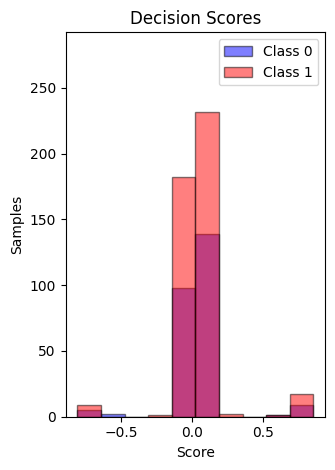

In [142]:
# Visualization taken from sklearn
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_twoclass.html#sphx-glr-auto-examples-ensemble-plot-adaboost-twoclass-py


twoclass_output = binary_classifier.decision_function(X)
plot_range = (twoclass_output.min(), twoclass_output.max())
plt.subplot(122)
class_names = "01"
plot_colors = "br"
for i, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(
        twoclass_output[binary_y == i],
        bins=10,
        range=plot_range,
        facecolor=c,
        label="Class %s" % n,
        alpha=0.5,
        edgecolor="k",
    )
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, y1, y2 * 1.2))
plt.legend(loc="upper right")
plt.ylabel("Samples")
plt.xlabel("Score")
plt.title("Decision Scores")

plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
plt.show()

In [ ]:
# Learning Rate

estimators = [10,50,100,150,200]
score = []

for n in estimators:

    classifier = AdaBoostClassifier(n_estimators= n)
    score.append(cross_val_score(classifier, X_train, binary_y_train).mean())

plt.plot(estimators, score)
plt.title("Relationship Between Accuracy and Number Estimators")
plt.ylabel("Cross Validation Accuracy")
plt.xlabel("Number of Estimators in Boosting Algorithm")
plt.show()

In [ ]:
# Algorithm

estimators = [10,50,100,150,200]
score = []

for n in estimators:

    classifier = AdaBoostClassifier(n_estimators= n)
    score.append(cross_val_score(classifier, X_train, binary_y_train).mean())

plt.plot(estimators, score)
plt.title("Relationship Between Accuracy and Number Estimators")
plt.ylabel("Cross Validation Accuracy")
plt.xlabel("Number of Estimators in Boosting Algorithm")
plt.show()